# Predict the closing price, Model: SARIMAX, Stock Token: CMG, Train/Test/Validation/: 70/20/10
- Dataset: 1252 rows x 7 columns (01/03/2019 - 01/03/2024) - exogenous variable: low price
----
### Model evaluation (Test set)
- RMSE: 704.69
- MAE: 554.11
- MAPE: 1.69 %

### Import neccesary libraries


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    mean_absolute_percentage_error as mape,
    root_mean_squared_error as rmse,
    mean_absolute_error as mae,
)
from sklearn.linear_model import LinearRegression

### Define the split type and stock name


In [2]:
# Split: [0] = 70% 20% 10% | [1] = 60% 20% 20% | [2] = 80% 10% 10%
split_type = [[0.7, 0.2], [0.6, 0.2], [0.8, 0.1]]
# Stock [0] = FPT | [1] = CMG | [2] = ITD
stock_name = ["FPT", "CMG", "ITD"]

In [3]:
# Choose the split_type and stock_name -> CMG - 7 2 1
split = 0  # 7 2 1
stock = 1  # CMG

## 1.Data preprocessing


In [4]:
# Loading data
df = pd.read_csv(f"../../Dataset/{stock_name[stock]}_stock.csv")
df

,time,open,high,low,close,volume,ticker
0,2019-03-01,13590,13590,13360,13480,9850,CMG
1,2019-03-04,13550,14060,13550,13970,118020,CMG
2,2019-03-05,13830,14490,13830,14460,222050,CMG
3,2019-03-06,14460,14720,13850,14060,224770,CMG
4,2019-03-07,14340,14340,13830,13830,112670,CMG
...,...,...,...,...,...,...,...
1308,2024-05-27,60500,61100,57000,59000,2265500,CMG
1309,2024-05-28,59800,62400,59200,62100,1479800,CMG
1310,2024-05-29,62100,63400,60000,60000,2384000,CMG
1311,2024-05-30,59000,60100,58100,59200,1814100,CMG


In [5]:
# Take the close price of FPT a
df = df[["low", "close"]]

df

,low,close
0,13360,13480
1,13550,13970
2,13830,14460
3,13850,14060
4,13830,13830
...,...,...
1308,57000,59000
1309,59200,62100
1310,60000,60000
1311,58100,59200


In [6]:
df.reset_index(drop=True)
df

,low,close
0,13360,13480
1,13550,13970
2,13830,14460
3,13850,14060
4,13830,13830
...,...,...
1308,57000,59000
1309,59200,62100
1310,60000,60000
1311,58100,59200


In [7]:
# Shape of the dataframe
df.shape

(1313, 2)

In [8]:
df.dtypes

low      int64
close    int64
dtype: object

In [9]:
# Describe the dataframe
df.describe()

,low,close
count,1313.000000,1313.000000
mean,26235.587205,26832.390708
std,9802.115234,10097.555228
min,10780.000000,10880.000000
25%,17540.000000,17810.000000
50%,27510.000000,28380.000000
75%,33440.000000,34350.000000
max,63000.000000,63600.000000


## 2. Train model


In [10]:
# Defining the split size
train_size = int(split_type[split][0] * len(df))
test_size = int(split_type[split][1] * len(df))
val_size = len(df) - train_size - test_size

In [11]:
# splitting data into train, test and validation set
train_data = df[:train_size]
test_data = df[train_size : train_size + test_size]
val_data = df[train_size + test_size :]

In [12]:
# splitting sets into independent and dependent variable
X_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data["close"])

X_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data["close"])

X_val = np.array(val_data.index).reshape(-1, 1)
y_val = np.array(val_data["close"])

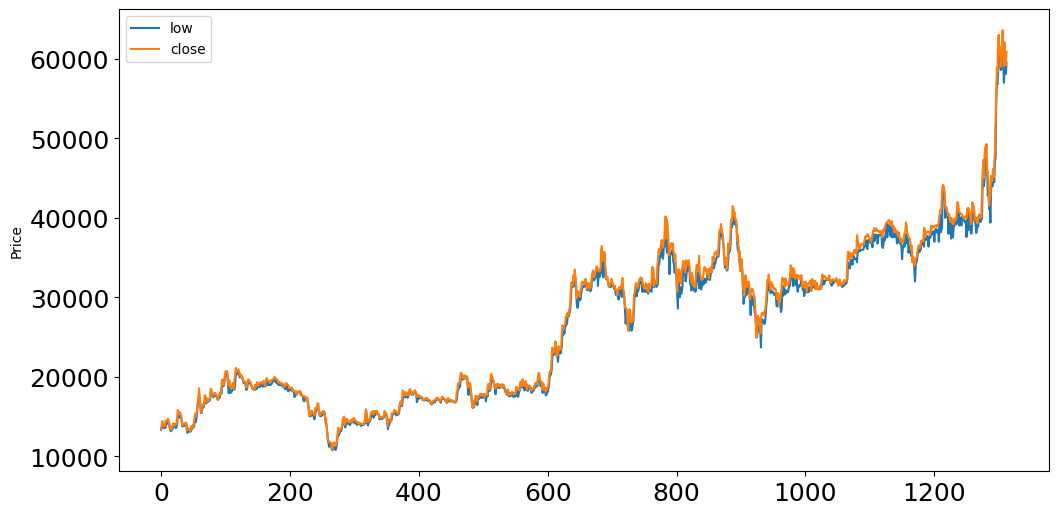

In [13]:
# Draw plot to look the dataset
df.plot(figsize=(12, 6), fontsize=18)
plt.ylabel("Price")
plt.show()

### Low price and close price are correlated => Good for SARIMAX model


In [14]:
# Check if the dataset is stationary or not
from statsmodels.tsa.stattools import adfuller

adfuller(df["close"])

(0.9665029450963428,
 0.9938996357719839,
 21,
 1291,
 {'1%': -3.4354254066484664,
  '5%': -2.863781366113082,
  '10%': -2.56796331977745},
 20590.753479727184)

The high p-value close to 1 suggests that we fail to reject the null hypothesis -> the data is likely non-stationary.


In [15]:
# Agugmented Dickey-Fuller test
def adf_test(dataset, name):
    dftest = adfuller(dataset, autolag="AIC", regression="ct")
    print(f"ADF Test on '{name}' -> p-value: {dftest[1]:.3f}")
    if (
        dftest[0] < dftest[4]["5%"]
        or dftest[0] < dftest[4]["1%"]
        or dftest[0] < dftest[4]["10%"]
    ):
        print("\033[92mReject Ho - Time Series is Stationary\033[0m")
        return True
    else:
        print("\033[91mFailed to Reject Ho - Time Series is Non-Stationary\033[0m")
        return False

In [16]:
# Differencing all features for stationarity until all features are stationary
is_all_stationary = False
diff_order = 0
while not is_all_stationary:
    print("*" * 50 + f" Differencing of order {diff_order} " + "*" * 50)
    train_diff = pd.DataFrame(
        np.diff(train_data, diff_order, axis=0), columns=train_data.columns
    )
    if all([adf_test(train_diff[feature], feature) for feature in train_diff.columns]):
        is_all_stationary = True
        print(f"Dataset is stationary after differencing of order {diff_order}")
        break
    diff_order += 1

************************************************** Differencing of order 0 **************************************************
ADF Test on 'low' -> p-value: 0.438
Failed to Reject Ho - Time Series is Non-Stationary


ADF Test on 'close' -> p-value: 0.571
Failed to Reject Ho - Time Series is Non-Stationary
************************************************** Differencing of order 1 **************************************************
ADF Test on 'low' -> p-value: 0.000
Reject Ho - Time Series is Stationary
ADF Test on 'close' -> p-value: 0.000
Reject Ho - Time Series is Stationary
Dataset is stationary after differencing of order 1


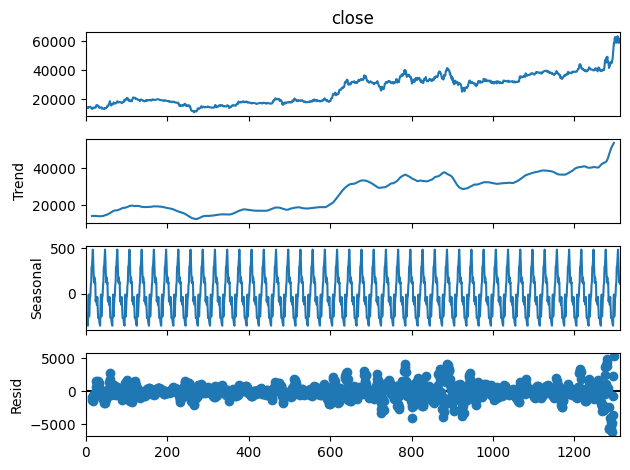

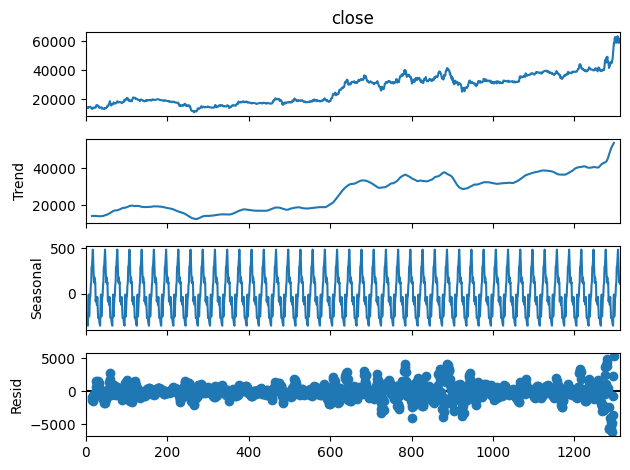

In [17]:
# Decompose the data to see the trend, seasonality and noise
from statsmodels.tsa.seasonal import seasonal_decompose

decompose = seasonal_decompose(df["close"], model="additive", period=30)
decompose.plot()

In [18]:
df1 = df
df_diff = np.diff(train_data["close"], n=1)

In [19]:
# Check again
adfuller(df_diff)

(-23.06833677840579,
 0.0,
 1,
 916,
 {'1%': -3.4375090829661534,
  '5%': -2.864700447588469,
  '10%': -2.5684528237924527},
 14059.177727416965)

The p-value is 1.04^-15, less than 0.05 -> Dataset is stationary -> Draw ACF to find m


<Figure size 1000x600 with 0 Axes>

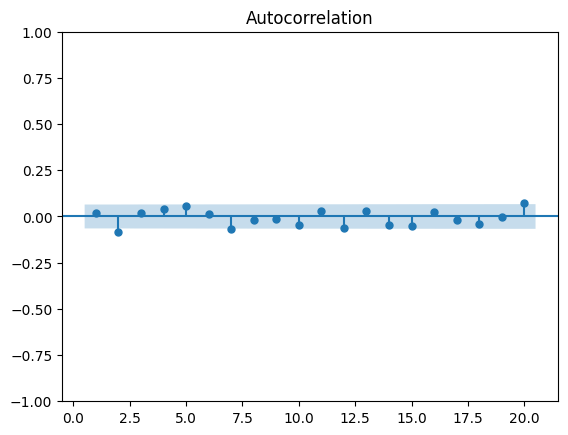

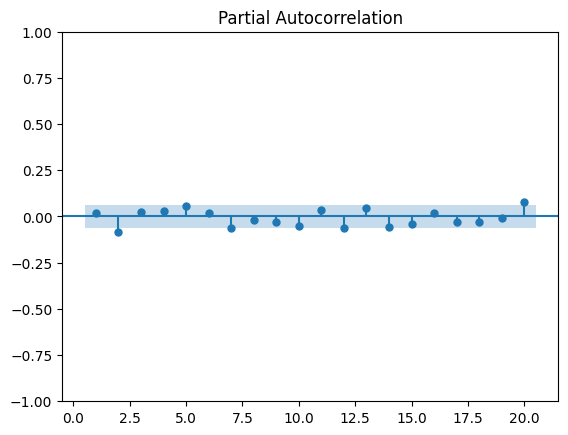

In [20]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.figure(figsize=(10, 6))
plot_acf(df_diff, lags=20, zero=False)
plot_pacf(df_diff, lags=20, zero=False)
plt.show()

=> m = 5


In [21]:
# Review the dataset again
df

,low,close
0,13360,13480
1,13550,13970
2,13830,14460
3,13850,14060
4,13830,13830
...,...,...
1308,57000,59000
1309,59200,62100
1310,60000,60000
1311,58100,59200


In [22]:
# Use auto_arima to find the best (p, d, q) and (P, D, Q)
from pmdarima.arima import auto_arima

model = auto_arima(
    y_train,
    trace=True,
    d=1,
    max_p=7,
    max_d=7,
    error_action="ignore",
    suppress_warnings=True,
    seasonal=True,
    m=5,
)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[5] intercept   : AIC=inf, Time=4.29 sec
 ARIMA(0,1,0)(0,0,0)[5] intercept   : AIC=14393.492, Time=0.03 sec
 ARIMA(1,1,0)(1,0,0)[5] intercept   : AIC=14394.229, Time=0.13 sec
 ARIMA(0,1,1)(0,0,1)[5] intercept   : AIC=14393.916, Time=0.25 sec
 ARIMA(0,1,0)(0,0,0)[5]             : AIC=14392.381, Time=0.02 sec
 ARIMA(0,1,0)(1,0,0)[5] intercept   : AIC=14392.532, Time=0.14 sec
 ARIMA(0,1,0)(0,0,1)[5] intercept   : AIC=14392.253, Time=0.13 sec
 ARIMA(0,1,0)(1,0,1)[5] intercept   : AIC=14393.860, Time=0.50 sec
 ARIMA(0,1,0)(0,0,2)[5] intercept   : AIC=14393.059, Time=0.32 sec
 ARIMA(0,1,0)(1,0,2)[5] intercept   : AIC=14394.679, Time=0.81 sec
 ARIMA(1,1,0)(0,0,1)[5] intercept   : AIC=14393.959, Time=0.25 sec
 ARIMA(1,1,1)(0,0,1)[5] intercept   : AIC=14394.016, Time=0.64 sec
 ARIMA(0,1,0)(0,0,1)[5]             : AIC=14391.016, Time=0.20 sec
 ARIMA(0,1,0)(1,0,1)[5]             : AIC=14392.658, Time=0.65 sec
 ARIMA(0,1,0)(0,0,2)[5]  

In [23]:
print(model.summary())

                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                  919
Model:             SARIMAX(0, 1, 0)x(0, 0, [1], 5)   Log Likelihood               -7193.508
Date:                             Thu, 06 Jun 2024   AIC                          14391.016
Time:                                     22:25:51   BIC                          14400.660
Sample:                                          0   HQIC                         14394.697
                                             - 919                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.S.L5        0.0620      0.022      2.773      0.006       0.018       0.106
sigma2      3.748e+05   1.0

#### Use SARIMAX to train model


In [24]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Use 'low price' for the exogenous variable
model1 = SARIMAX(
    y_train,
    exog=np.array(train_data["low"]),
    order=(2, 1, 2),
    seasonal_order=(0, 0, 0, 5),
)

model_fit = model1.fit()

### Test


In [25]:
exg = np.array(test_data["low"])

y_pred_test = model_fit.predict(
    start=len(y_train), end=len(y_test) + len(y_train) - 1, exog=exg
)

y_pred_test

array([30094.55937872, 30828.80208736, 29338.16829444, 29340.74300001,
       28090.72189875, 26323.97927801, 26399.19914334, 27799.36651732,
       27103.97793162, 28241.03734203, 26878.44474938, 26803.2672276 ,
       25149.36162747, 28532.350343  , 28241.03742529, 28391.39247936,
       28316.21495238, 27949.72450851, 27949.72450851, 28720.29415974,
       29782.17672789, 30627.92390607, 31699.2036651 , 32798.67499673,
       31915.33905508, 32798.67499673, 32065.69410897, 31548.8486112 ,
       31952.92781855, 31840.16152813, 31764.98400118, 31548.8486112 ,
       31548.8486112 , 31332.71322122, 31548.8486112 , 31436.08232077,
       30082.88683569, 30007.70930874, 30994.41434995, 31398.4935573 ,
       30007.70930874, 30082.88683569, 30449.37727957, 29340.50875707,
       29706.99920094, 31548.8486112 , 31257.53569427, 32432.18455285,
       32065.69410897, 31398.4935573 , 31915.33905508, 31548.8486112 ,
       31764.98400118, 31840.16152813, 31699.2036651 , 32140.87163592,
      

#### Validate


In [26]:
exg = np.array(val_data["low"])

y_pred_val = model_fit.predict(
    start=len(X_train), end=len(X_train) + len(y_val) - 1, exog=exg
)

y_pred_val

array([37414.97106539, 37482.01322236, 37504.32715929, 37065.23389403,
       38906.88858856, 38098.65943642, 37835.58043048, 38202.05680891,
       38314.82663792, 38314.82595322, 37064.99965099, 38164.47098779,
       38098.69064446, 38155.0737925 , 38812.87715251, 38483.97547228,
       38624.93333528, 38859.863107  , 38859.863107  , 37638.22829408,
       38906.84906135, 39141.77883306, 39141.77883306, 38718.90524397,
       38859.863107  , 39047.80692438, 37638.22829408, 40034.51196558,
       40833.27318942, 38765.89119832, 39047.80692438, 39329.72265043,
       43746.4023587 , 43840.37426738, 43746.4023587 , 43088.59899789,
       40457.38555467, 41256.14677851, 41256.14677851, 40739.30128073,
       40504.37150901, 38577.94738094, 40175.46982861, 40316.42769164,
       39987.52601124, 38014.11592882, 40128.48387427, 39470.68051346,
       38155.07379185, 39423.69455912, 39517.66646781, 39987.52601124,
       39705.61028518, 39705.61028518, 39799.58219387, 40786.28723507,
      

### Predict the next 30/60/90 days


In [27]:
# Predict next xx days
num_of_days_30 = 30
num_of_days_60 = 60
num_of_days_90 = 90

In [28]:
df

,low,close
0,13360,13480
1,13550,13970
2,13830,14460
3,13850,14060
4,13830,13830
...,...,...
1308,57000,59000
1309,59200,62100
1310,60000,60000
1311,58100,59200


In [29]:
from sklearn.linear_model import LinearRegression

ln_model = LinearRegression()

# Use LM to find the low price the next 30/60/90 days
ln_model.fit(np.array(train_data.index).reshape(-1, 1), train_data["low"])

last_index = df.index[-1]
last_data_30 = pd.RangeIndex(start=last_index, stop=last_index + num_of_days_30, step=1)
last_data_60 = pd.RangeIndex(start=last_index, stop=last_index + num_of_days_60, step=1)
last_data_90 = pd.RangeIndex(start=last_index, stop=last_index + num_of_days_90, step=1)

# Extrapolation variable
exog = np.array(val_data["low"])

# Create an array of 30/60/90 consecutive integers starting from last_index
x_30_days_pred = np.array(
    range(last_index + 1, last_index + num_of_days_30 + 1)
).reshape(-1, 1)

x_60_days_pred = np.array(
    range(last_index + 1, last_index + num_of_days_60 + 1)
).reshape(-1, 1)

x_90_days_pred = np.array(
    range(last_index + 1, last_index + num_of_days_90 + 1)
).reshape(-1, 1)

# Predict the low price - extrapolation variable for the next 30/60/90 days to predict the closeing price
low_30_days_pred = ln_model.predict(x_30_days_pred)
low_60_days_pred = ln_model.predict(x_60_days_pred)
low_90_days_pred = ln_model.predict(x_90_days_pred)

# Predict the closing prices of FPT for the next 30/60/90 days
y_30_days_pred = model_fit.predict(
    start=len(X_train),
    end=len(X_train) + len(x_30_days_pred) - 1,
    exog=low_30_days_pred,
)

y_60_days_pred = model_fit.predict(
    start=len(X_train),
    end=len(X_train) + len(x_60_days_pred) - 1,
    exog=low_60_days_pred,
)

y_90_days_pred = model_fit.predict(
    start=len(X_train),
    end=len(X_train) + len(x_90_days_pred) - 1,
    exog=low_90_days_pred,
)

# Print the predicted closing prices for the next 30 days
print("Predicted closing prices for the next 30 days:")
print(y_30_days_pred)

Predicted closing prices for the next 30 days:
[42315.22354535 42404.41979044 42411.29905202 42436.02784571
 42457.9872181  42480.07056878 42502.26699529 42524.40701796
 42546.56464466 42568.71804809 42590.8722195  42613.0263128
 42635.18039366 42657.33448461 42679.48857194 42701.64266023
 42723.79674833 42745.95083645 42768.10492457 42790.25901269
 42812.41310081 42834.56718893 42856.72127705 42878.87536517
 42901.02945329 42923.18354141 42945.33762953 42967.49171765
 42989.64580577 43011.7998939 ]


### Plotting the data


In [30]:
def draw_plot(x_next_days, y_next_day, days):
    plt.figure(figsize=(10, 6))
    plt.plot(train_data.index, train_data["close"], label="Train")
    plt.plot(test_data.index, test_data["close"], label="Test")
    plt.plot(val_data.index, val_data["close"], label="Validate")

    plt.plot(test_data.index, y_pred_test, label="Predicted Test", linestyle="--")
    plt.plot(val_data.index, y_pred_val, label="Predicted Validate", linestyle="--")

    plt.plot(
        x_next_days, y_next_day, label=f"Predicted Next {days} days", linestyle="--"
    )
    plt.title(f"{stock_name[stock]} Stock Price Prediction Using SARIMAX")
    plt.legend()
    plt.show()

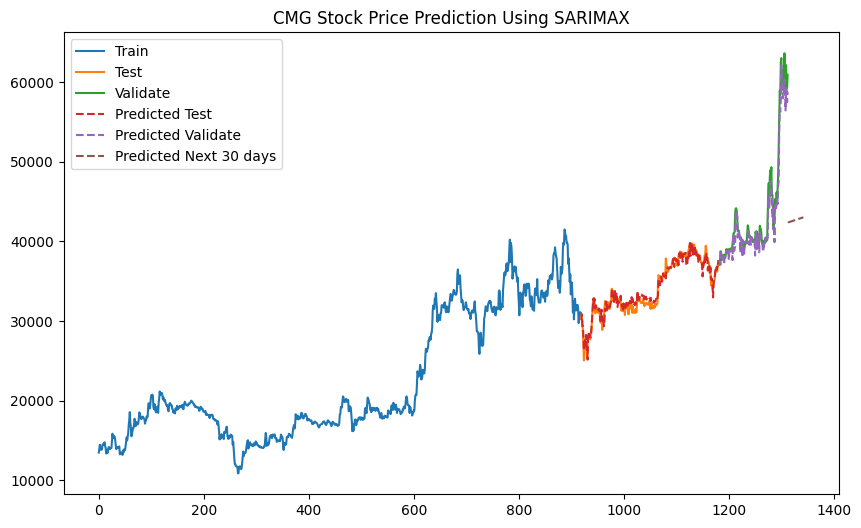

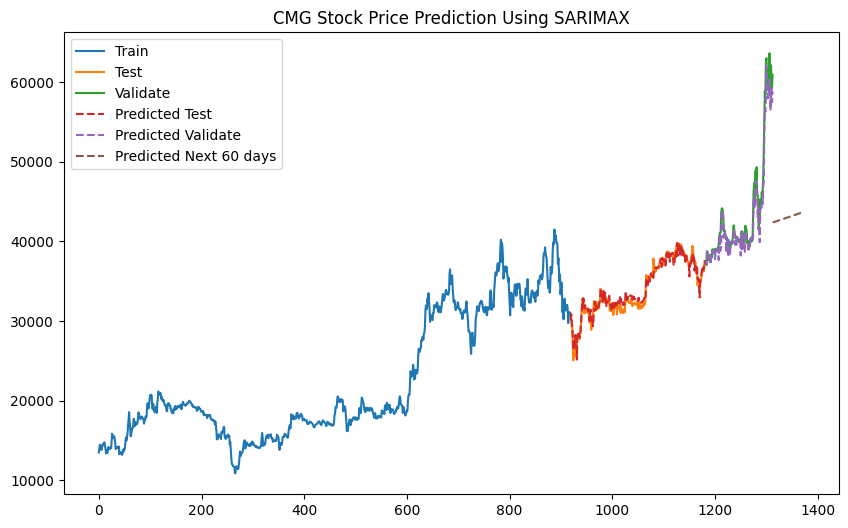

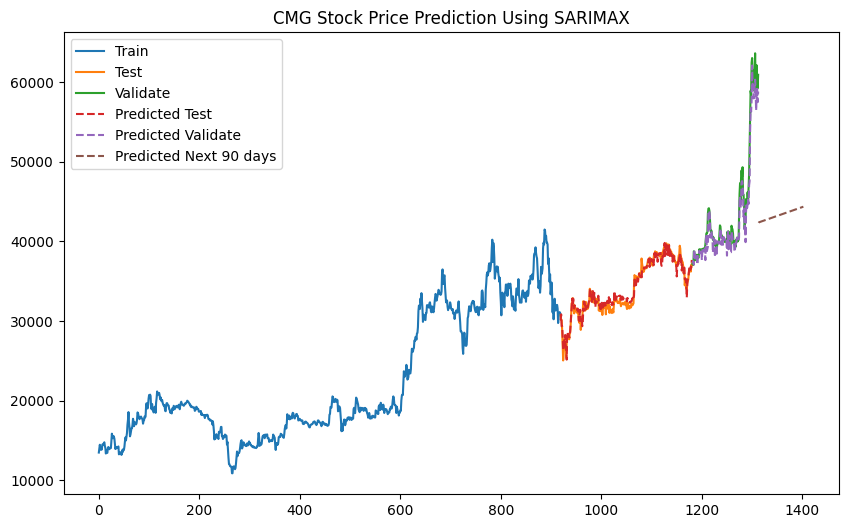

In [31]:
draw_plot(x_30_days_pred, y_30_days_pred, 30)
draw_plot(x_60_days_pred, y_60_days_pred, 60)
draw_plot(x_90_days_pred, y_90_days_pred, 90)

## 3. Model evaluation


In [32]:
# Model evaluation on test set
print(f"RMSE on test data: {rmse(y_test, y_pred_test)}")
print(f"MAE on test data: {mae(y_test, y_pred_test)}")
print(f"MAPE on test data: {mape(y_test, y_pred_test) * 100} %")

RMSE on test data: 649.3417041965682
MAE on test data: 507.61769225360615
MAPE on test data: 1.53099169769304 %


In [33]:
# Model evaluation on validation set
print(f"RMSE on validation data: {rmse(y_val, y_pred_val)}")
print(f"MAE on validation data: {mae(y_val, y_pred_val)}")
print(f"MAPE on validation data: {mape(y_val, y_pred_val) * 100} %")

RMSE on validation data: 1343.7345988025163
MAE on validation data: 891.1082115596228
MAPE on validation data: 1.9032915293057295 %
